In [1]:
from Pipeline import BLEPipeline, WifiPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

**Get packet features**

In [4]:
b = BLEPipeline()
b.extract_packet_features(create_master=False)

Old ./BLE_Source deleted
Total number of packets processed:  4285634
Total data processing time:  4622.92540789
Normalized total processing time per 25k packets:  26.9675700718
Total capture file processing time:  940.718348742
Normalized capture file processing time:  5.48762650253


**Produce dataframe**

In [7]:
df = b.make_dataframe()

August2    224739
Energy1     79039
Energy2     71741
Home1       58810
Home2       58614
Push        32761
Kevo        21107
August1     17314
Weather      8643
Room2        8133
Room1        7728
Door1        7374
Door2        4154
Name: Name, dtype: int64


**Prep dataframe**

In [13]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

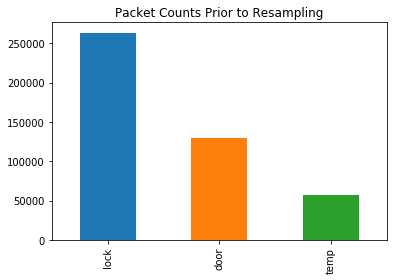

In [24]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#

devtype_df = df["DeviceType"].value_counts()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

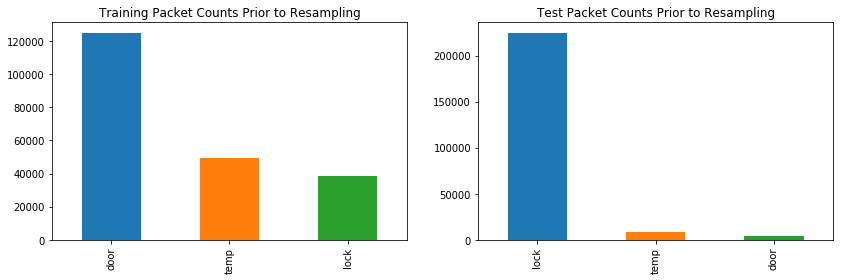

In [63]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
devtype_train = df_train["DeviceType"].value_counts()
plt.subplot(1, 2, 1) #
devtype_train.plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
devtype_test = df_test["DeviceType"].value_counts()
plt.subplot(1, 2, 2)
devtype_test.plot(kind='bar', title="Test Packet Counts Prior to Resampling");


In the training set, the 'door' class has the most packets, with the 'lock' class having the least. 
In the test set, the 'lock' class has the most packets, with the 'door' class having the least. 

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


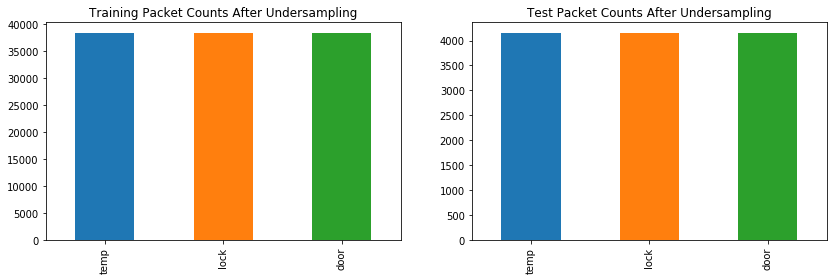

In [65]:
# 1st technique - Random undersampling: 
#     randomly removing packets of the majority classes to match the minority class

# Undersampling training set
# Get class counts
count_door, count_temp, count_lock = devtype_train

# Find minority class
count_minority = min(count_door, count_lock, count_temp)

# Separate by class
devtype_train_door = df_train[df["DeviceType"]=='door'];
devtype_train_temp = df_train[df["DeviceType"]=='temp'];
devtype_train_lock = df_train[df["DeviceType"]=='lock']; # Minority class

# Undersample majority classes to minority class count
devtype_train_door = devtype_train_door.sample(count_minority)
devtype_train_temp = devtype_train_temp.sample(count_minority)

# Combine back into one dataframe
df_train_undersampled = pd.concat([devtype_train_door, devtype_train_temp, devtype_train_lock], axis=0)

#-------------------------------------------------------------------------------------------------

# Undersampling test set
# Get class counts
count_lock, count_temp, count_door = devtype_test

# Find minority class
count_minority = min(count_door, count_lock, count_temp)

# Separate by class
devtype_test_door = df_test[df["DeviceType"]=='door']; # Minority class
devtype_test_temp = df_test[df["DeviceType"]=='temp'];
devtype_test_lock = df_test[df["DeviceType"]=='lock']; 

# Undersample majority classes to minority class count
devtype_test_lock = devtype_test_lock.sample(count_minority)
devtype_test_temp = devtype_test_temp.sample(count_minority)

# Combine back into one dataframe
df_test_undersampled = pd.concat([devtype_test_door, devtype_test_temp, devtype_test_lock], axis=0)


#-------------------------------------------------------------------------------------------------

# Plot changes
plt.subplots(1, 2, figsize=(14,4))
plt.subplot(1, 2, 1)
df_train_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Undersampling");

plt.subplot(1, 2, 2)
df_test_undersampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Undersampling");

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


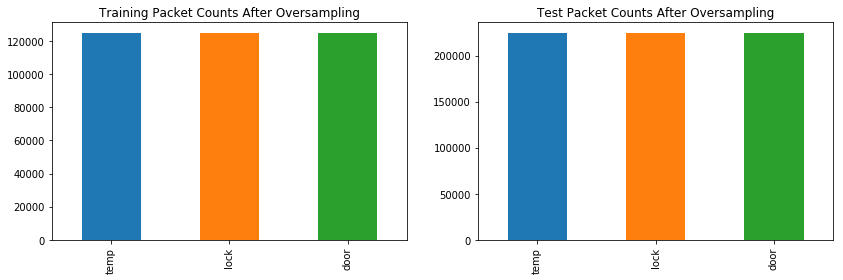

In [68]:
# 2nd technique - Random oversampling: 
#     randomly resampling packets of the minority classes to match the count of the majority class

# Oversampling training set
# Get class counts
count_door, count_temp, count_lock = devtype_train

# Find majority class
count_majority = max(count_door, count_lock, count_temp)

# Separate by class
devtype_train_door = df_train[df["DeviceType"]=='door'];# Majority class
devtype_train_temp = df_train[df["DeviceType"]=='temp'];
devtype_train_lock = df_train[df["DeviceType"]=='lock']; 

# Oversample majority classes to majority class count
devtype_train_door = devtype_train_door.sample(count_majority, replace=True)
devtype_train_temp = devtype_train_temp.sample(count_majority, replace=True)
devtype_train_lock = devtype_train_lock.sample(count_majority, replace=True)

# Combine back into one dataframe
df_train_oversampled = pd.concat([devtype_train_door, devtype_train_temp, devtype_train_lock], axis=0)

#-------------------------------------------------------------------------------------------------

# Oversampling test set
# Get class counts
count_lock, count_temp, count_door = devtype_test

# Find majority class
count_majority = max(count_door, count_lock, count_temp)

# Separate by class
devtype_test_door = df_test[df["DeviceType"]=='door'];
devtype_test_temp = df_test[df["DeviceType"]=='temp'];
devtype_test_lock = df_test[df["DeviceType"]=='lock']; 

# Oversample majority classes to minority class count
devtype_test_lock = devtype_test_lock.sample(count_majority, replace=True)
devtype_test_temp = devtype_test_temp.sample(count_majority, replace=True)
devtype_test_door = devtype_test_door.sample(count_majority, replace=True)

# Combine back into one dataframe
df_test_oversampled = pd.concat([devtype_test_door, devtype_test_temp, devtype_test_lock], axis=0)


#-------------------------------------------------------------------------------------------------

# Plot changes
plt.subplots(1, 2, figsize=(14,4))
plt.subplot(1, 2, 1)
df_train_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Training Packet Counts After Oversampling");

plt.subplot(1, 2, 2)
df_test_oversampled["DeviceType"].value_counts().plot(kind='bar', title="Test Packet Counts After Oversampling");

**Create feature list**

In [69]:
# # Run One vs All  and One vs One classification strategies
# features_list = [
# #     'AccessAddr', 'AdvertAddr', 'ScanAddr',
#     'BLE_LL_Length', 'TxAddr', 'CompanyID',
# #     'RFChannel',
#     'PacketLength', 'Time', 'Assoc_Packets',
#     'ADV_DIRECT_IND', 'ADV_IND', 'ADV_NONCONN_IND', 
#     'ADV_SCAN_IND', 'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP']

# y_list = ["door", "lock", "plug", "temp"]

One vs all
Device Type: door
Random Forest Score: 0.03878899361251508 Time:  1.25428891182
KNN Score: 0.9743994329735979 Time:  103.754995108
LDA Score: 0.03437597563136534 Time:  0.340323925018
Total time (classifiers): 105.349692822

Device Type: lock
Random Forest Score: 0.2745184072633382 Time:  1.04208707809
KNN Score: 0.9978441183667615 Time:  103.307614088
LDA Score: 0.05184663285884249 Time:  0.339652061462
Total time (classifiers): 104.689419031

Device Type: plug
Random Forest Score: 0.9999746863213318 Time:  0.951542139053
KNN Score: 0.9977470825985335 Time:  103.337182999
LDA Score: 0.0950655202382861 Time:  0.349932193756
Total time (classifiers): 104.638740063

Device Type: temp
Random Forest Score: 0.9786225983647363 Time:  1.04567193985
KNN Score: 0.9750491507260807 Time:  103.189161062
LDA Score: 0.9656915275117498 Time:  0.332150936127
Total time (classifiers): 104.567066908

Total time (one vs all_classify): 419.3985641

One vs one
Device Pair: ('door', 'lock')
Rando

**Run classification algorithms**

In [ ]:
# time_start = time.time()

# print "One vs all"
# one_vs_all_classify(df, features_list, y_list)

# print "One vs one"
# one_vs_one_classify(df, features_list, y_list)

# print "Total time (one vs one & one vs all classification):", time.time() - time_start